In [1]:
%load_ext autoreload
%autoreload 2

# get project dir
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

pp = PurePath(Path.cwd()).parts[:]
pdir = PurePath(*pp)
data_script_dir = pdir / 'src' / 'data'
bars_script_dir = pdir / 'src' / 'features'
sys.path.append(data_script_dir.as_posix())
sys.path.append(bars_script_dir.as_posix())
viz_dir = pdir / 'reports' / 'figures'
data_dir = pdir / 'data'

# import python scientific stack
import pandas as pd
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
# from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from utils import *
from bars import *
from labelling import *
from mpEngine import *
from sampleWeights import *


RANDOM_STATE = 777

print()

In [2]:
infp = PurePath(data_dir/'processed'/'IVE_dollarValue_resampled_1s.parquet')
df = pd.read_parquet(infp)


In [3]:
df['dates'] = df.index
dbars = dollar_bar_df(df,'dv',1_000_000).drop_duplicates().dropna()
dbars = dbars.drop(['dates'],axis = 1)

In [4]:
close = dbars.price.copy()
dailyVol = getDailyVol(close)

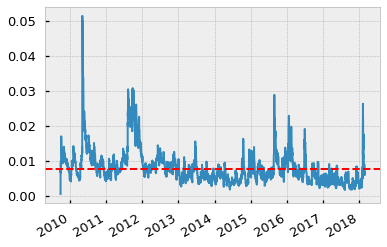

In [5]:
f, ax = plt.subplots()
dailyVol.plot(ax = ax)
ax.axhline(dailyVol.mean(),ls='--',color='red')

In [6]:
from tqdm import tqdm, tqdm_notebook

tEvents = getTEvents(close, h = dailyVol.mean())
t1 = addVerticalBarrier(tEvents,close)

ptSl = [1,1]
target = dailyVol

# select minRet
minRet = 0.001
# Run in single-threaded mode on Windows
import platform

if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1

events = getEvents(close, tEvents, ptSl, target, minRet, 1, t1 = t1)

numThreads = cpus

numCoEvents = mpPandasObj(mpNumCoEvents,
                          ('molecule', events.index),
                          numThreads,
                          closeIdx = close.index,
                          t1 = events['t1'])

## Plot the time series of the number of concurrent labels on the primary axis and the time series of exponentially weighted moving standard deviation of returns on the secondary axis

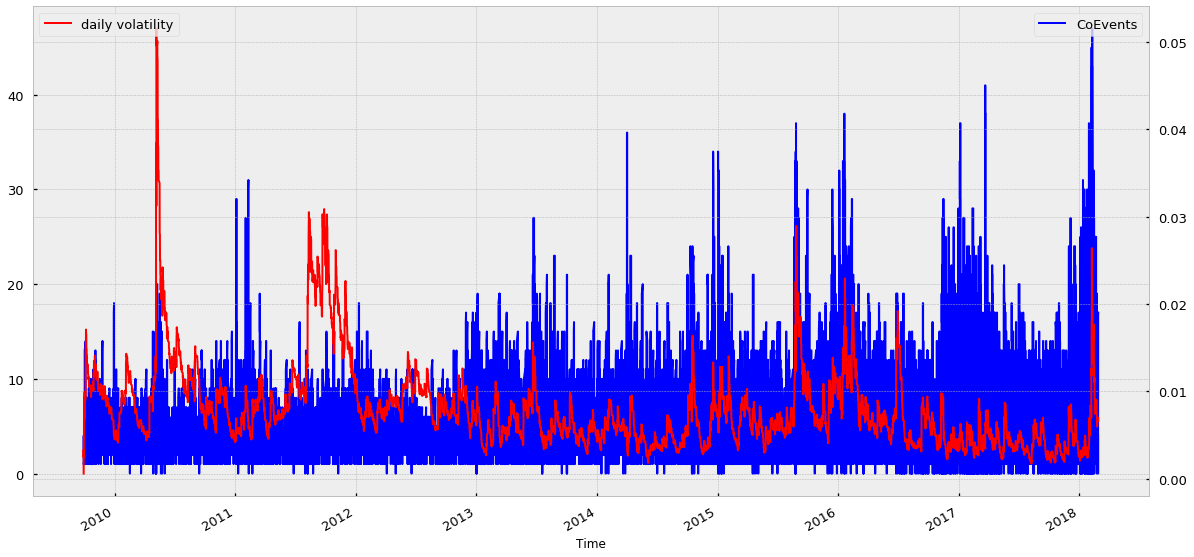

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.xlabel('Time')

ax1 = numCoEvents.plot(color='blue', grid=True, label='CoEvents')
ax2 = dailyVol.plot(color='red', grid=True, secondary_y=True, label='daily volatility')

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

## Produce a scatter plot of the number of concurrent labels and the exponentially weighted moving standard deviation of returns

In [8]:
coEvents = numCoEvents.to_frame()

ewmasd = dailyVol.to_frame()

combine = ewmasd.join(coEvents, how = 'inner')

combine.columns = ['ewmasd', 'coEvents']

combine['ewmasd_std'] = (combine['ewmasd']-combine['ewmasd'].mean())/combine['ewmasd'].std()

combine['coEvents_std'] = (combine['coEvents']-combine['coEvents'].mean())/combine['coEvents'].std()

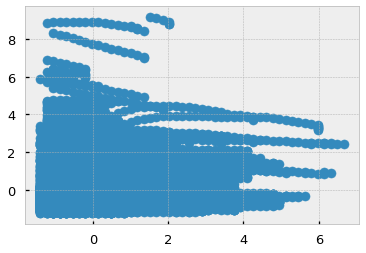

In [9]:
plt.scatter(combine['coEvents_std'],combine['ewmasd_std'])

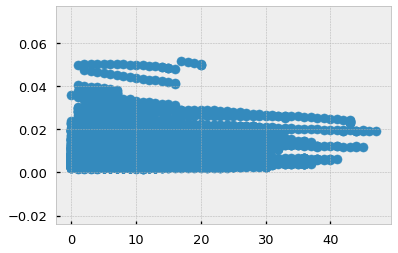

In [10]:
plt.scatter(combine['coEvents'],combine['ewmasd'])

## Compute the average uniqueness of each label

In [11]:
sampleTW = SampleTW(close = close, events = events, numThreads = numThreads)

In [12]:
cprint(sampleTW)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                     t1        tW
2018-02-26 15:20:10 2018-02-26 16:16:14  0.060994
2018-02-26 15:24:32 2018-02-26 16:16:14  0.060743
2018-02-26 15:31:06 2018-02-26 16:16:14  0.059559
2018-02-26 15:40:15 2018-02-26 16:16:14  0.058824
2018-02-26 15:49:42 2018-02-26 16:16:14  0.058824
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25404 entries, 2009-09-29 11:18:50 to 2018-02-26 15:49:42
Data columns (total 2 columns):
t1    25404 non-null datetime64[ns]
tW    25404 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 MB
None
-------------------------------------------------------------------------------



In [13]:
import statsmodels.tsa.ar_model as ar_model
ar = ar_model.AR(sampleTW['tW'])
tw_ar1 = ar.fit(maxlag=1)

In [14]:
tw_ar1.params

const    0.043641
L1.tW    0.671643
dtype: float64

In [15]:
tw_ar1.pvalues

const    0.0
L1.tW    0.0
dtype: float64

In [16]:
 sampleTW['tW'].sum()/sampleTW.shape[0] # << 1

0.13299755423884296

## Fit a random forest to a financial dataset
## The mean out of bag accuracy

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
from sklearn.preprocessing import StandardScaler

C:\Users\rex.wong\AppData\Local\conda\conda\envs\myenv\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

Xy = (pd.DataFrame()
      .assign(close=close,
              close_lag=close.shift(1))
     ).dropna()

y = Xy.loc[:,'close'].values
X = Xy.loc[:,'close_lag'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    shuffle=False)

n_estimator = 50
rf = RandomForestRegressor(max_depth=1, n_estimators=n_estimator,
                           criterion='mse', oob_score=True,
                           random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
rf.oob_score_

0.8467303001656034

## What is the mean accuracy of the k-fold cv on the same dataset?

In [19]:
from sklearn.model_selection import cross_validate

n_estimator = 50
rf = RandomForestRegressor(max_depth=1, n_estimators=n_estimator,
                           criterion='mse', oob_score=True,
                           random_state=RANDOM_STATE)

scores = cross_validate(rf, X, y, cv=5)

In [20]:
scores

{'fit_time': array([0.35299993, 0.34799981, 0.39978552, 0.34318233, 0.33898401]),
 'score_time': array([0.00700021, 0.00699997, 0.        , 0.        , 0.        ]),
 'test_score': array([-33.46727124,  -2.56588386,  -6.24865531,  -0.7598279 ,
        -13.56185687]),
 'train_score': array([0.73071013, 0.80758277, 0.76192868, 0.75771226, 0.83111415])}

## Why is oob accuracy so much higher than cross-validation accuracy? Which is more correct/less biased? What' s the source of this bias

OOB accuracy is higher than croo-validation as the incorrect assumption of IID draws leads to oversampling of reducdant samples.
For random forest, it means that the trees are too similar. The random sampling also means that in-bag and out-of-bag samplie will be similar which inflating the out-of-bag accuracy.
In this example, the cv is less-biased


## Consider you have applied meta-labels to events determined by a trend-following model. Suppose 2/3 of labels are 0 and 1/3 are 1.

(a) What happens if you fit a classifier without balancing class weights?

The classifier will maximize accuracy by over predicting the dominant class

(b) A label 1 means true positive and a label 0 means a false positive. By applying balanced class weights, we are forcing the classifier to pay more attention to the true positives, and less attention to the false positives. Why does that make sense?

Tying the output to real-life purpose means that too many false positives result in bad trades/investments which means lost capital. From a ML perspective without balanced class weights we will maximize accuracy by simply predicting the dominant class. We need to improve precision: TP/(TP+FP) relative to recall: TP/(TP+FN) not just overall accuracy (TP+TN)/(TP+FP+TN+FN).

(c) What is the distribution of the predicted labels, before and after applying balanced class weights?

Before balanced class weights is an unbalanced or skewed distribution. After balanced class weights predicted labels would be more evenly distributed depending on the predictive power of the feature set.


In [21]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [22]:
window=50
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)
cprint(bb_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price      ave    upper    lower
2018-02-26 15:31:06  115.29  114.005  114.959  113.051
2018-02-26 15:40:15  115.41  114.069  115.008  113.129
2018-02-26 15:49:42  115.20  114.124  115.047  113.202
2018-02-26 15:59:04  115.27  114.183  115.083  113.282
2018-02-26 16:16:14  115.30  114.231  115.125  113.338
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30812 entries, 2009-10-01 15:51:02 to 2018-02-26 16:16:14
Data columns (total 4 columns):
price    30812 non-null float64
ave      30812 non-null float64
upper    30812 non-null float64
lower    30812 non-null float64
dtypes: float64(4)
memory usage: 1.2 MB
None
-------------------------------------------------------------------------------



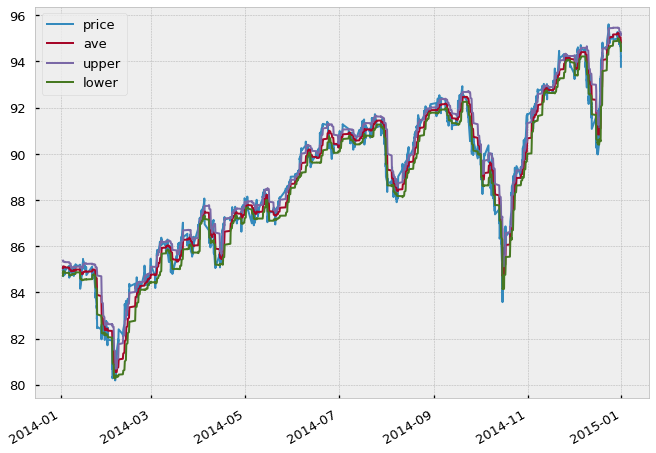

In [23]:
f,ax=plt.subplots(figsize=(11,8))
bb_df.loc['2014'].plot(ax=ax)

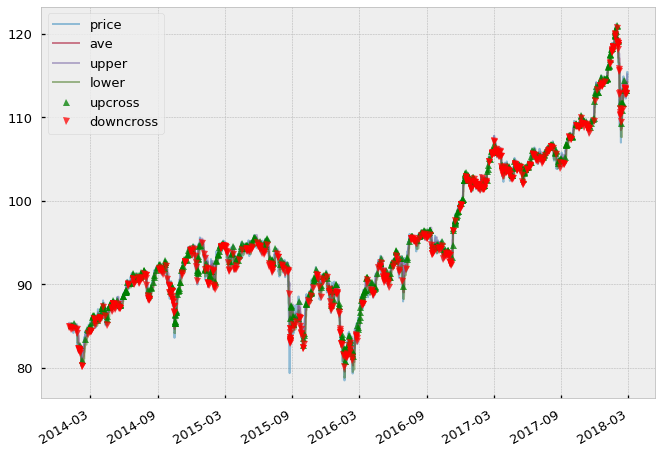

In [24]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price') 

f, ax = plt.subplots(figsize=(11,8))

bb_df.loc['2014':].plot(ax=ax, alpha=.5)
bb_up.loc['2014':].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc['2014':].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()

In [25]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()
cprint(bb_side_raw)

minRet = .01 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=bb_side_raw)
cprint(bb_events)

bb_side = bb_events.dropna().side
cprint(bb_side)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
2018-02-22 13:34:29  1
2018-02-22 14:20:25  1
2018-02-22 14:44:33  1
2018-02-23 13:41:26 -1
2018-02-23 14:40:49 -1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2009-10-06 09:29:52 to 2018-02-23 14:40:49
Data columns (total 1 columns):
0    2039 non-null int64
dtypes: int64(1)
memory usage: 31.9 KB
None
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     side                  t1      trgt
2018-02-15 12:54:31   NaN 2018-02-16 09:30:00  0.010491
2018-02-15 13:21:31   NaN 2018-02-16 09:30:

In [26]:
bb_side.value_counts()

-1.0    161
 1.0    119
Name: side, dtype: int64

In [27]:
bb_bins = getBins(bb_events,close).dropna()
cprint(bb_bins)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2018-02-13 14:13:57  0.005608  1.0
2018-02-13 14:57:38  0.005282  1.0
2018-02-13 15:17:59  0.005462  1.0
2018-02-14 10:19:18 -0.016789  0.0
2018-02-15 11:52:44 -0.004374  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280 entries, 2009-10-06 14:52:03 to 2018-02-15 11:52:44
Data columns (total 2 columns):
ret    280 non-null float64
bin    280 non-null float64
dtypes: float64(2)
memory usage: 6.6 KB
None
-------------------------------------------------------------------------------



In [28]:
bb_bins.bin.value_counts()

1.0    141
0.0    139
Name: bin, dtype: int64

In [29]:

def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window)
            .corr(df.shift(lag))) # could .dropna() here

#df_rolling_autocorr(d1, window=21).dropna().head()

In [30]:
srl_corr = df_rolling_autocorr(returns(close), window=window).rename('srl_corr')
cprint(srl_corr)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     srl_corr
2018-02-26 15:31:06  0.028037
2018-02-26 15:40:15  0.015957
2018-02-26 15:49:42  0.032877
2018-02-26 15:59:04  0.046014
2018-02-26 16:16:14  0.109129
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30860 entries, 2009-09-28 10:06:04 to 2018-02-26 16:16:14
Data columns (total 1 columns):
srl_corr    30810 non-null float64
dtypes: float64(1)
memory usage: 482.2 KB
None
-------------------------------------------------------------------------------



In [31]:

features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
cprint(features)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          vol  srl_corr
2018-02-15 12:54:31  0.010491  0.011018
2018-02-15 13:21:31  0.010387  0.020206
2018-02-15 13:42:09  0.010285  0.022286
2018-02-15 14:05:41  0.010183 -0.033009
2018-02-15 14:11:21  0.010082 -0.112613
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5341 entries, 2009-10-05 10:41:50 to 2018-02-15 14:11:21
Data columns (total 2 columns):
vol         5341 non-null float64
srl_corr    5341 non-null float64
dtypes: float64(2)
memory usage: 125.2 KB
None
-------------------------------------------------------------------------------



In [32]:
Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
cprint(Xy)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          vol  srl_corr  bin
2018-02-15 11:07:21  0.011071  0.024360  0.0
2018-02-15 11:22:26  0.010968  0.013354  0.0
2018-02-15 11:29:54  0.010870  0.043957  0.0
2018-02-15 11:36:16  0.010766  0.043514  0.0
2018-02-15 11:52:44  0.010671  0.022724  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5335 entries, 2009-10-05 10:41:50 to 2018-02-15 11:52:44
Data columns (total 3 columns):
vol         5335 non-null float64
srl_corr    5335 non-null float64
bin         5335 non-null float64
dtypes: float64(3)
memory usage: 166.7 KB
None
-------------------------------------------------------------------------------



In [33]:
Xy.bin.value_counts()

0.0    2693
1.0    2642
Name: bin, dtype: int64

             precision    recall  f1-score   support

   no_trade       0.49      0.66      0.56      1308
      trade       0.51      0.34      0.41      1360

avg / total       0.50      0.50      0.48      2668



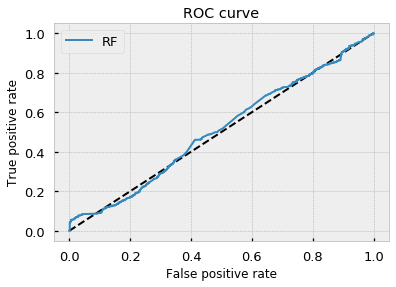

In [34]:
X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

             precision    recall  f1-score   support

   no_trade       0.50      0.69      0.58      1308
      trade       0.52      0.32      0.40      1360

avg / total       0.51      0.50      0.49      2668



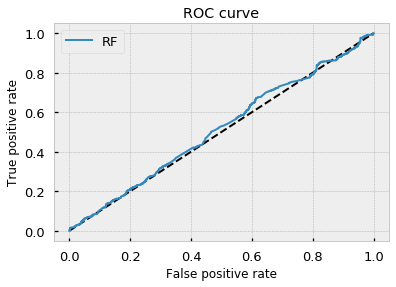

In [35]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)




n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train_std, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test_std)[:, 1]
y_pred = rf.predict(X_test_std)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

             precision    recall  f1-score   support

   no_trade       0.52      0.40      0.45      1308
      trade       0.53      0.64      0.58      1360

avg / total       0.52      0.52      0.52      2668



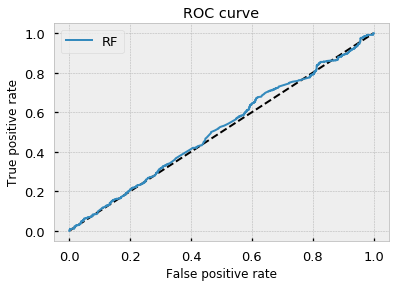

In [36]:
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE, class_weight = 'balanced_subsample')
rf.fit(X_train_std, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test_std)[:, 1]
y_pred = rf.predict(X_test_std)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()